# Problem 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random

In [2]:
import tensorflow as tf

In [3]:
import sys
sys.version

'3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]'

In [4]:
print(tf.__version__)

2.13.0


## Dataset Import

In [5]:
with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [6]:
train['features'].shape, valid['features'].shape, test['features'].shape

((34799, 32, 32, 3), (4410, 32, 32, 3), (12630, 32, 32, 3))

In [7]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Dataset analysis and visualization

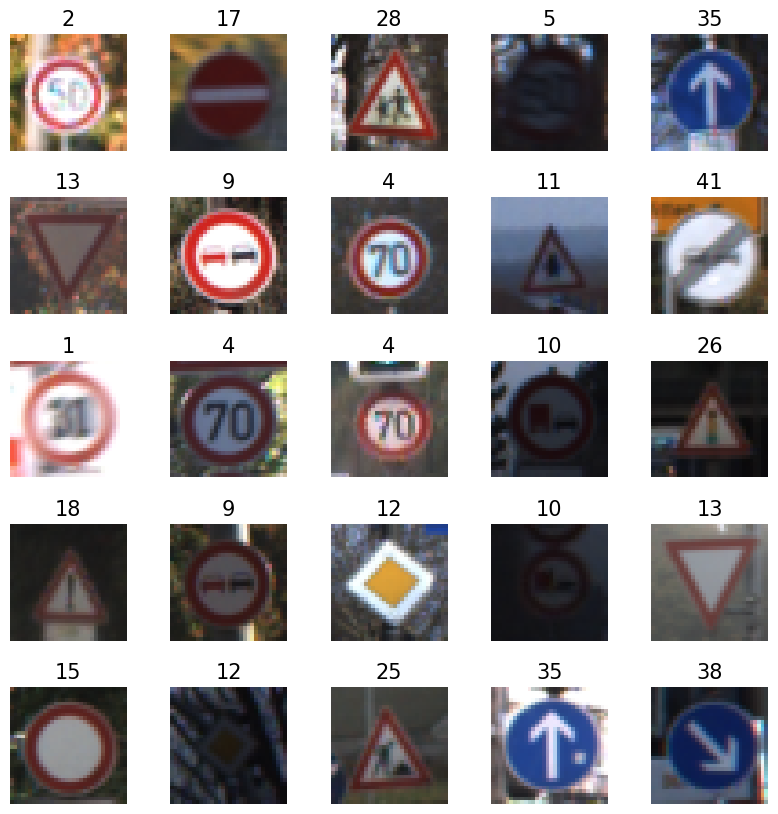

In [8]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow( X_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

        

### Number of sample per class in the training set

In [44]:
unique, counts = np.unique(train['labels'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 180, 1: 1980, 2: 2010, 3: 1260, 4: 1770, 5: 1650, 6: 360, 7: 1290, 8: 1260, 9: 1320, 10: 1800, 11: 1170, 12: 1890, 13: 1920, 14: 690, 15: 540, 16: 360, 17: 990, 18: 1080, 19: 180, 20: 300, 21: 270, 22: 330, 23: 450, 24: 240, 25: 1350, 26: 540, 27: 210, 28: 480, 29: 240, 30: 390, 31: 690, 32: 210, 33: 599, 34: 360, 35: 1080, 36: 330, 37: 180, 38: 1860, 39: 270, 40: 300, 41: 210, 42: 210}


## Shuffle training set

In [10]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Normalization

In [11]:
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)
X_validation_gray = np.sum(X_validation/3, axis = 3, keepdims = True)

In [12]:
X_train_gray_norm = (X_train_gray - 128)/128
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray - 128)/128

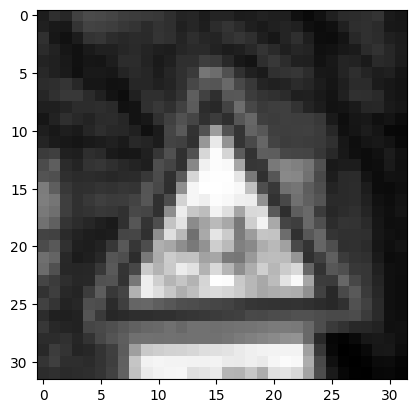

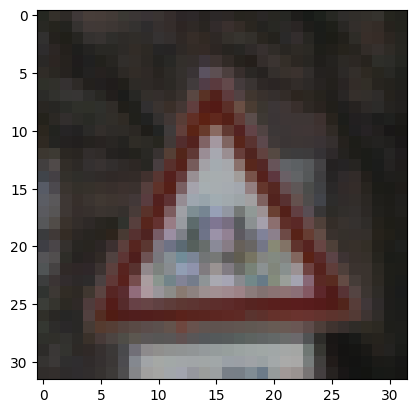

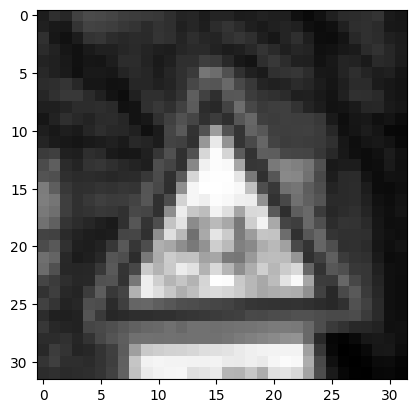

In [13]:
i = random.randint(1, len(X_train_gray))
plt.imshow(X_train_gray[i].squeeze(), cmap = 'gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')

## Model analysis

In [46]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models

In [59]:
def test_architecture(model, batch_size, epochs, early_stopping=False, es_patience=5):
    early_stopping_callback = EarlyStopping(monitor='loss', patience=es_patience)

    # train model
    history = model.fit(X_train_gray_norm,
                 y_train, 
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 1,
                 callbacks=[early_stopping_callback] if early_stopping else None,
                 validation_data = (X_validation_gray_norm, y_validation))

    # evaluate overall accuracy of the model
    score = model.evaluate(X_test_gray_norm, y_test)
    print('Test Accuracy: {}'.format(score[1]))

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    # plot accuracy over epochs
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # plot loss over epochs
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    predict_x=model.predict(X_test_gray_norm)
    predicted_classes=np.argmax(predict_x,axis=1)
    y_true = y_test

    # create confusion matrix
    cm = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize = (25, 25))
    sns.heatmap(cm, annot = True)

    # compute metrics per class
    precisions, recall, f1_score, _ = precision_recall_fscore_support(y_true, predicted_classes)
    model_metrics_df = pd.DataFrame({
        'Class': list(range(43)),
        'Precision': precisions,
        'Recall': recall,
        'F1-Score': f1_score
    })


    print(model_metrics_df)

## Model Architecture - Initial Version

In [63]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Conv2D(16, (5,5), activation = 'relu'))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))

CNN.add(layers.Dense(84, activation = 'relu'))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_8 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 400)               0         
                                                                 
 dense_21 (Dense)            (None, 120)              

Epoch 1/15
70/70 [==============================] - 8s 101ms/step - loss: 3.1880 - accuracy: 0.1717 - val_loss: 2.7359 - val_accuracy: 0.2966
Epoch 2/15
70/70 [==============================] - 7s 105ms/step - loss: 1.6725 - accuracy: 0.5350 - val_loss: 1.3323 - val_accuracy: 0.6202
Epoch 3/15
70/70 [==============================] - 7s 101ms/step - loss: 0.8794 - accuracy: 0.7498 - val_loss: 1.0095 - val_accuracy: 0.7197
Epoch 4/15
70/70 [==============================] - 7s 101ms/step - loss: 0.6322 - accuracy: 0.8251 - val_loss: 0.8930 - val_accuracy: 0.7551
Epoch 5/15
70/70 [==============================] - 7s 98ms/step - loss: 0.4961 - accuracy: 0.8657 - val_loss: 0.8212 - val_accuracy: 0.7717
Epoch 6/15
70/70 [==============================] - 7s 97ms/step - loss: 0.4072 - accuracy: 0.8937 - val_loss: 0.7408 - val_accuracy: 0.8093
Epoch 7/15
70/70 [==============================] - 7s 98ms/step - loss: 0.3485 - accuracy: 0.9105 - val_loss: 0.7158 - val_accuracy: 0.8077
Epoch 8/1

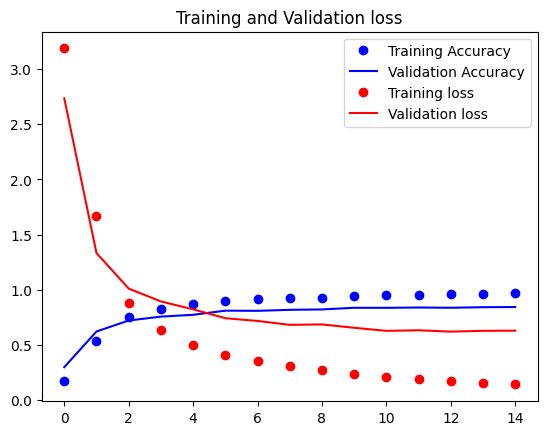

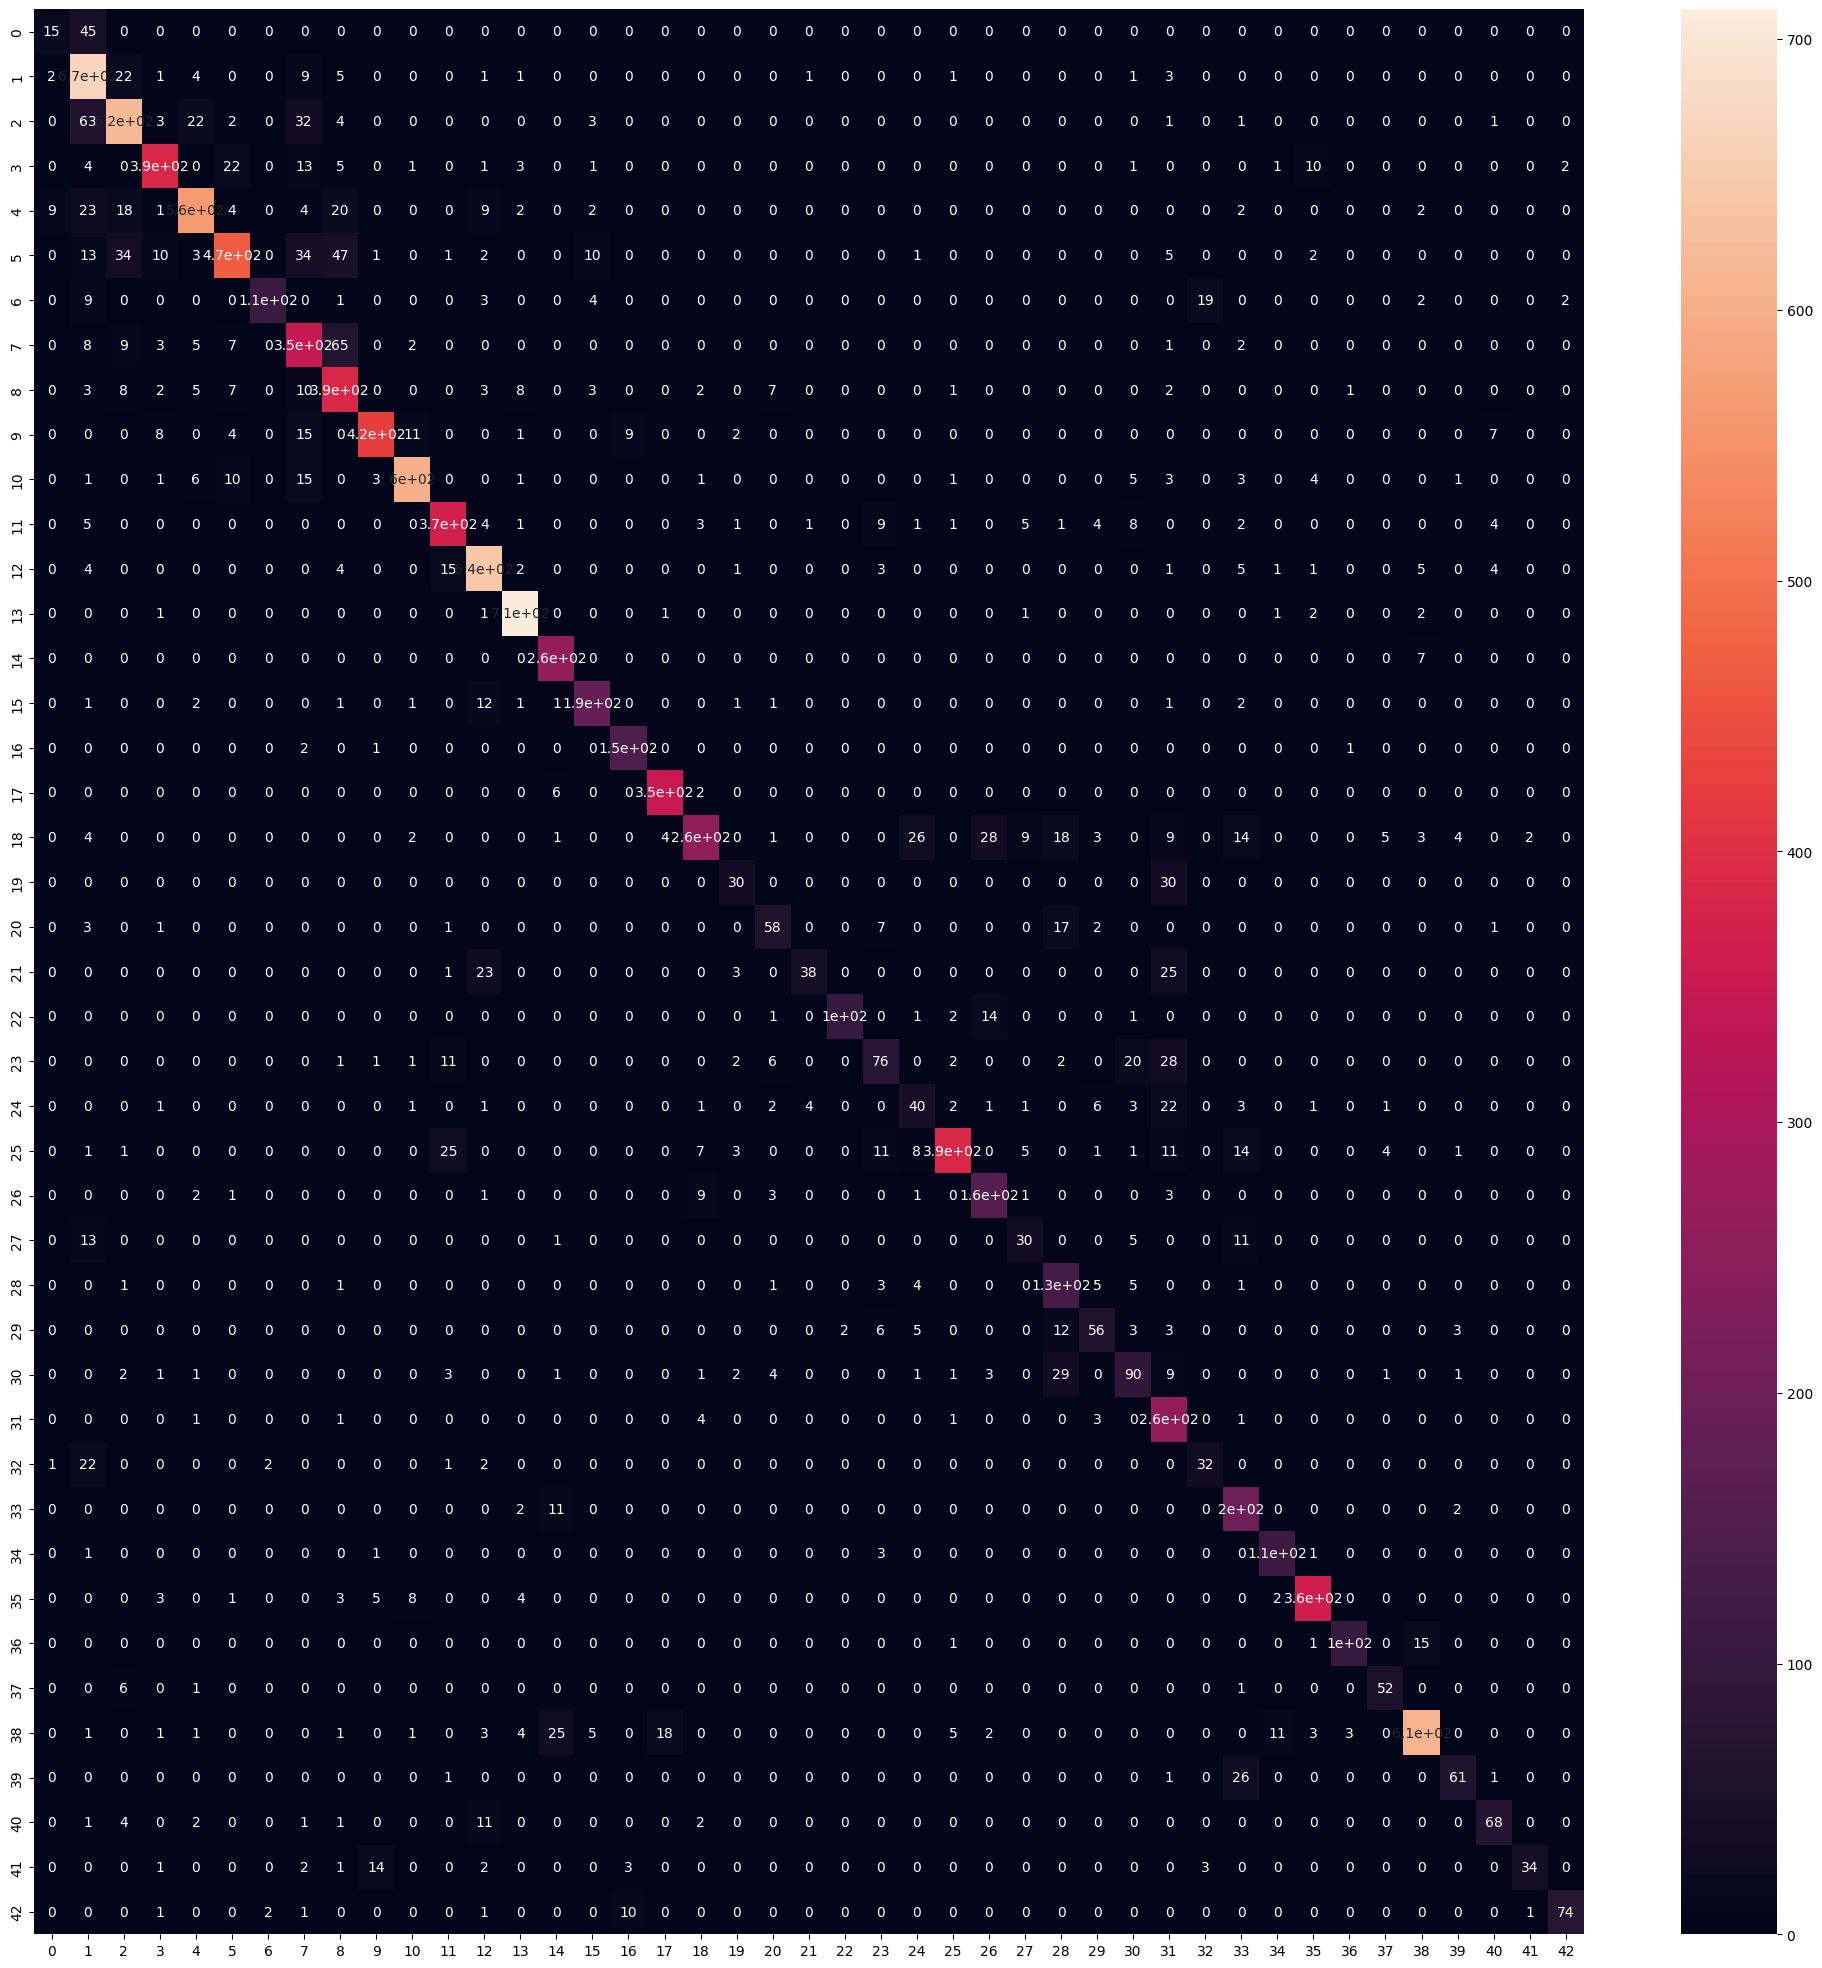

In [64]:
test_architecture(CNN, 500, 15)

## Model Architecture - 2nd Version

In [61]:
from tensorflow.keras import regularizers

CNN = models.Sequential()

CNN.add(layers.Conv2D(16, (5,5), activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(32, (5,5), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(84, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 5, 5, 32)         

Epoch 1/15
70/70 [==============================] - 14s 172ms/step - loss: 3.0166 - accuracy: 0.2225 - val_loss: 2.0888 - val_accuracy: 0.4642
Epoch 2/15
70/70 [==============================] - 12s 164ms/step - loss: 1.2174 - accuracy: 0.6637 - val_loss: 0.8617 - val_accuracy: 0.7778
Epoch 3/15
70/70 [==============================] - 11s 163ms/step - loss: 0.6305 - accuracy: 0.8325 - val_loss: 0.6011 - val_accuracy: 0.8431
Epoch 4/15
70/70 [==============================] - 11s 158ms/step - loss: 0.4424 - accuracy: 0.8897 - val_loss: 0.4524 - val_accuracy: 0.8916
Epoch 5/15
70/70 [==============================] - 12s 167ms/step - loss: 0.3408 - accuracy: 0.9178 - val_loss: 0.4030 - val_accuracy: 0.9009
Epoch 6/15
70/70 [==============================] - 11s 163ms/step - loss: 0.2856 - accuracy: 0.9345 - val_loss: 0.3813 - val_accuracy: 0.9036
Epoch 7/15
70/70 [==============================] - 11s 156ms/step - loss: 0.2423 - accuracy: 0.9470 - val_loss: 0.3460 - val_accuracy: 0.9168

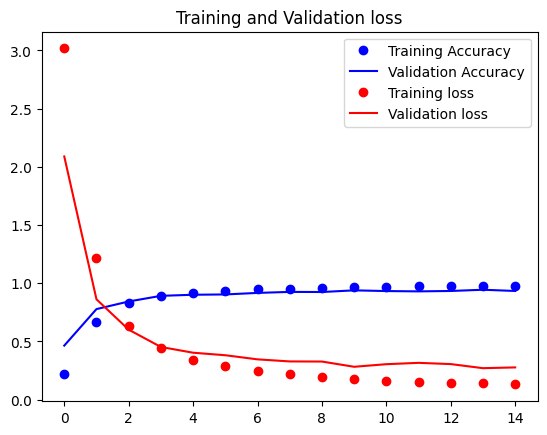

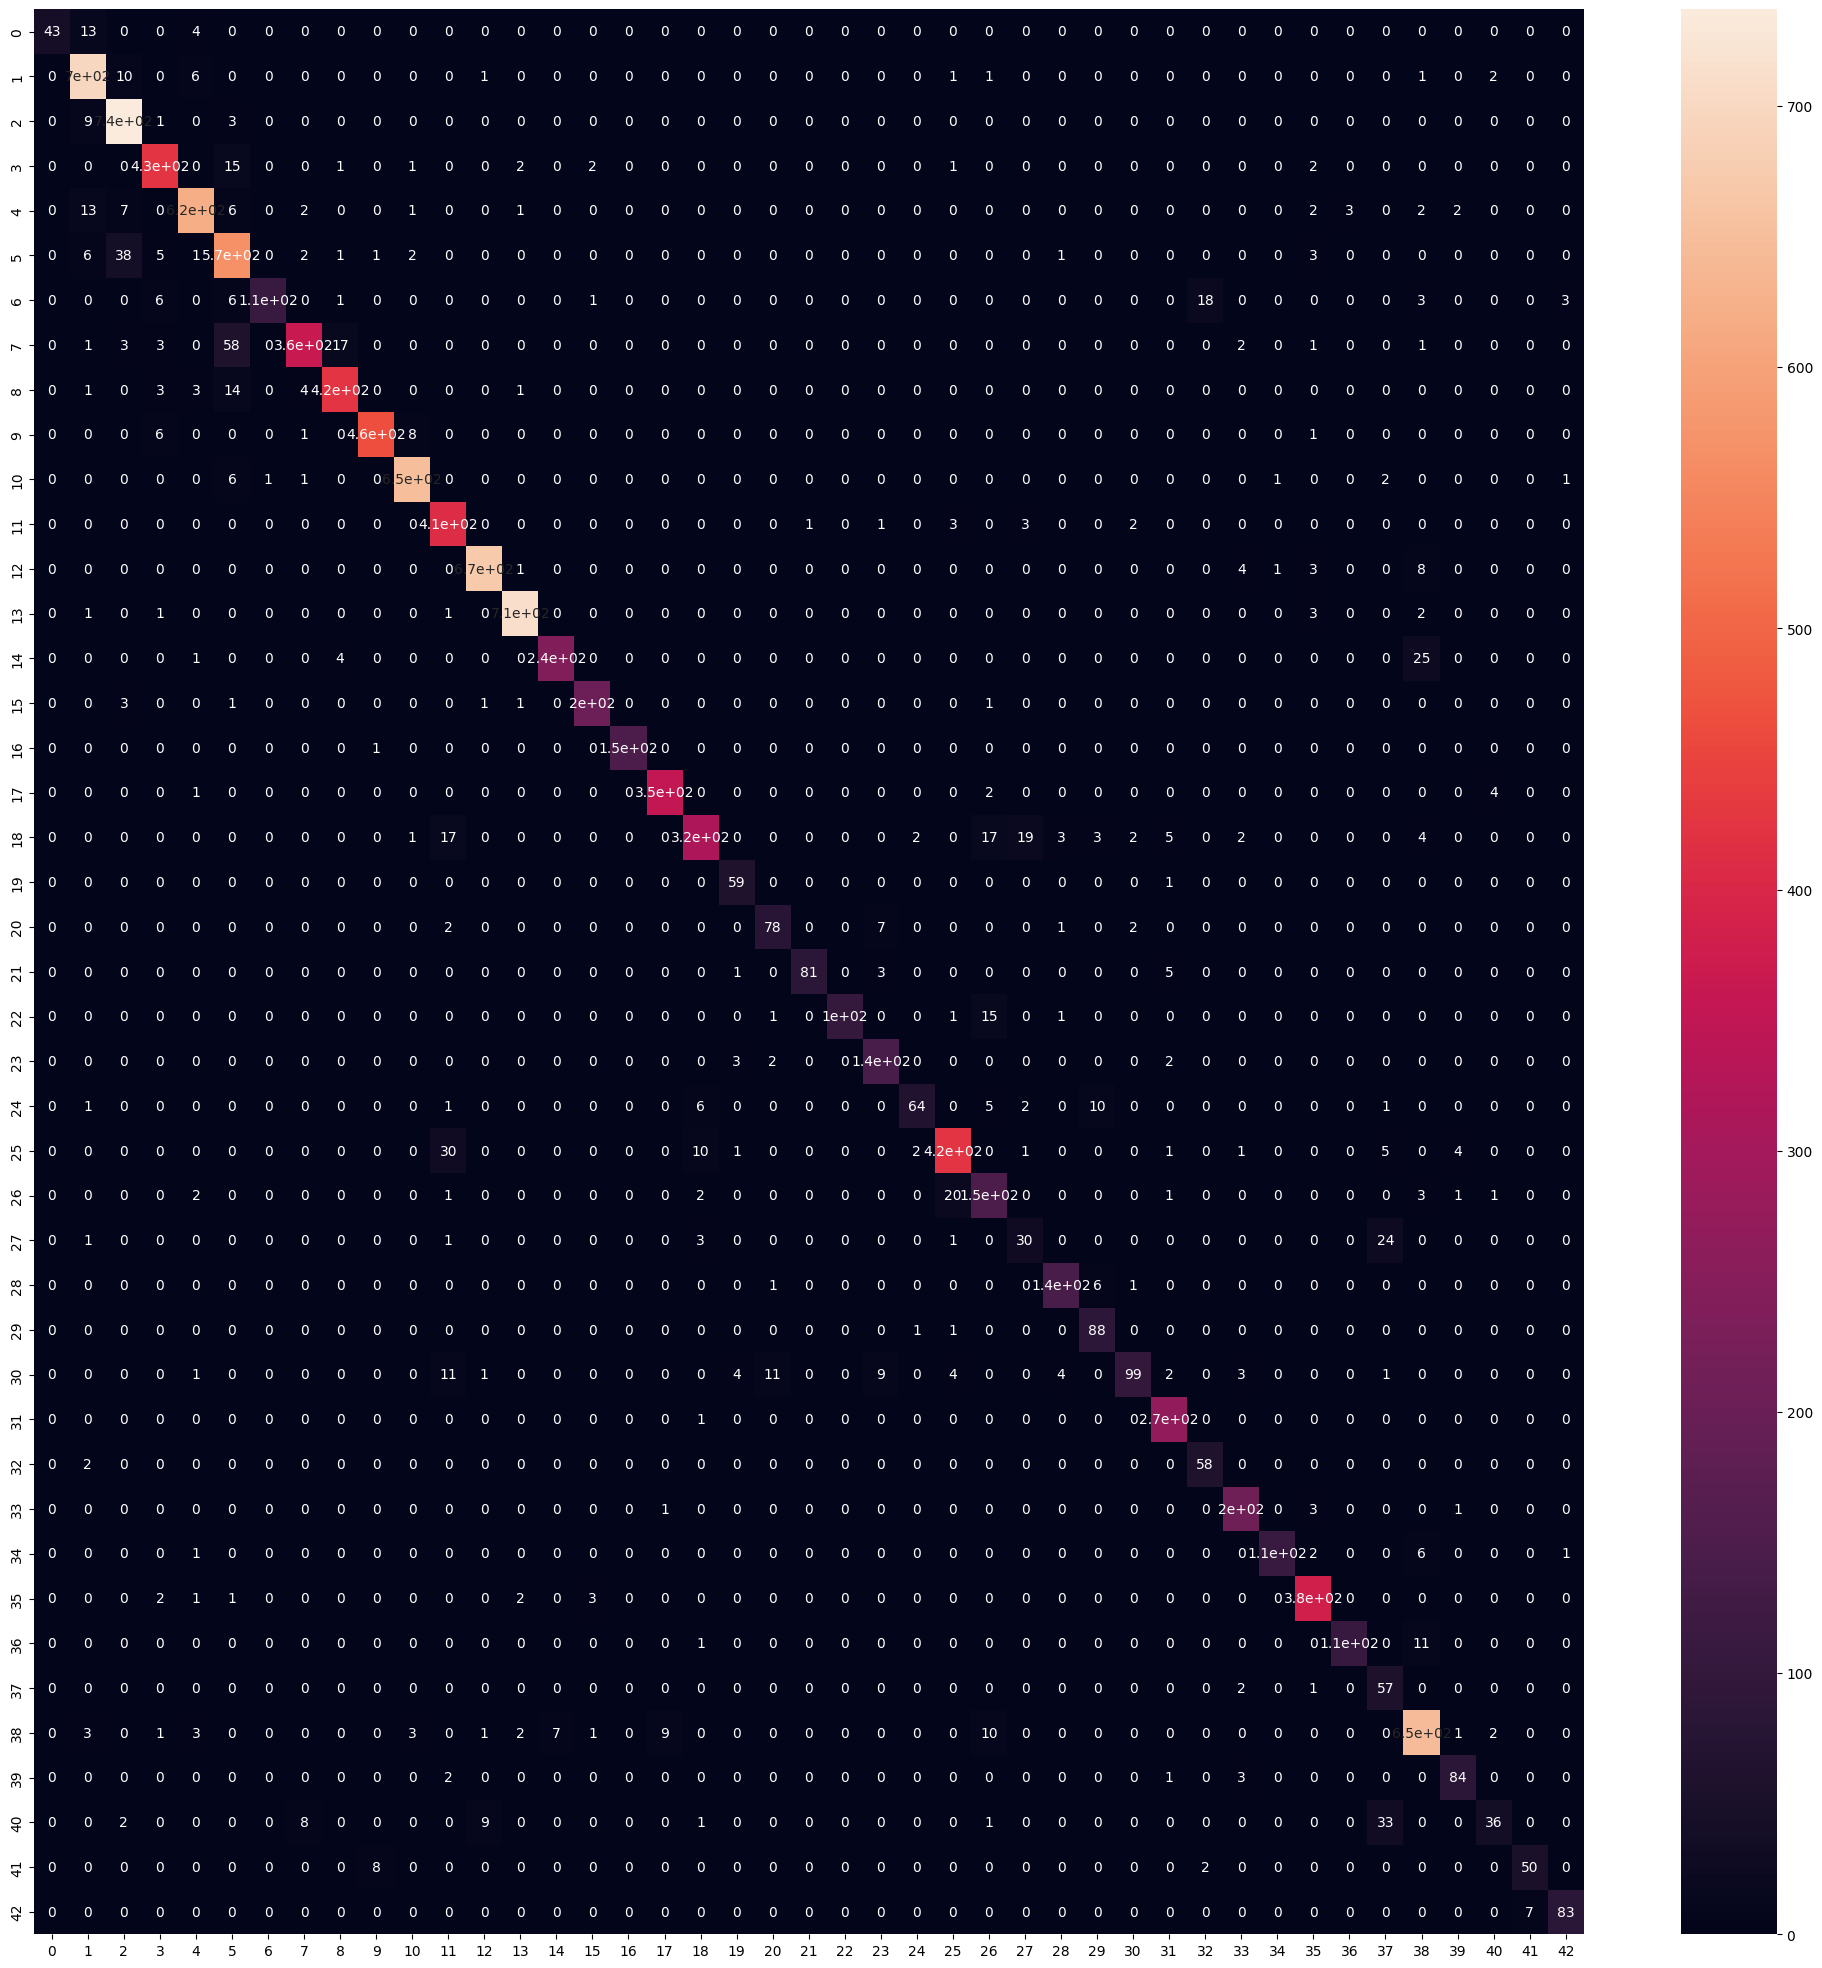

In [62]:
test_architecture(CNN, 500, 15, early_stopping=True, es_patience=6)

## Model Architecture - 3rd Version

In [65]:
from tensorflow.keras import regularizers

CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5,5), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Dropout(0.2))
#CNN.add(layers.Conv2D(16, (5,5), activation = 'relu'))
#CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(84, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_10 (Aver  (None, 14, 14, 6)         0         
 agePooling2D)                                                   
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 6)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_11 (Aver  (None, 5, 5, 16)          0         
 agePooling2D)                                                   
                                                                 
 dropout_10 (Dropout)        (None, 5, 5, 16)         

Epoch 1/15
70/70 [==============================] - 15s 186ms/step - loss: 3.2849 - accuracy: 0.1431 - val_loss: 2.8736 - val_accuracy: 0.2599
Epoch 2/15
70/70 [==============================] - 13s 186ms/step - loss: 2.0023 - accuracy: 0.4461 - val_loss: 1.4140 - val_accuracy: 0.5973
Epoch 3/15
70/70 [==============================] - 13s 188ms/step - loss: 1.1510 - accuracy: 0.6633 - val_loss: 0.9055 - val_accuracy: 0.7367
Epoch 4/15
70/70 [==============================] - 13s 183ms/step - loss: 0.8549 - accuracy: 0.7568 - val_loss: 0.7335 - val_accuracy: 0.7868
Epoch 5/15
70/70 [==============================] - 13s 188ms/step - loss: 0.7078 - accuracy: 0.8021 - val_loss: 0.6392 - val_accuracy: 0.8234
Epoch 6/15
70/70 [==============================] - 13s 191ms/step - loss: 0.6097 - accuracy: 0.8312 - val_loss: 0.5932 - val_accuracy: 0.8322
Epoch 7/15
70/70 [==============================] - 14s 196ms/step - loss: 0.5304 - accuracy: 0.8562 - val_loss: 0.5389 - val_accuracy: 0.8519

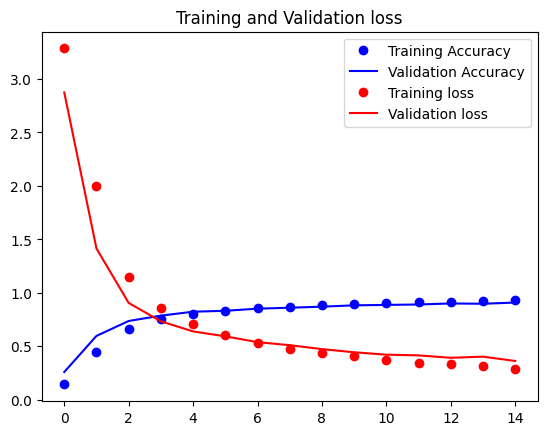

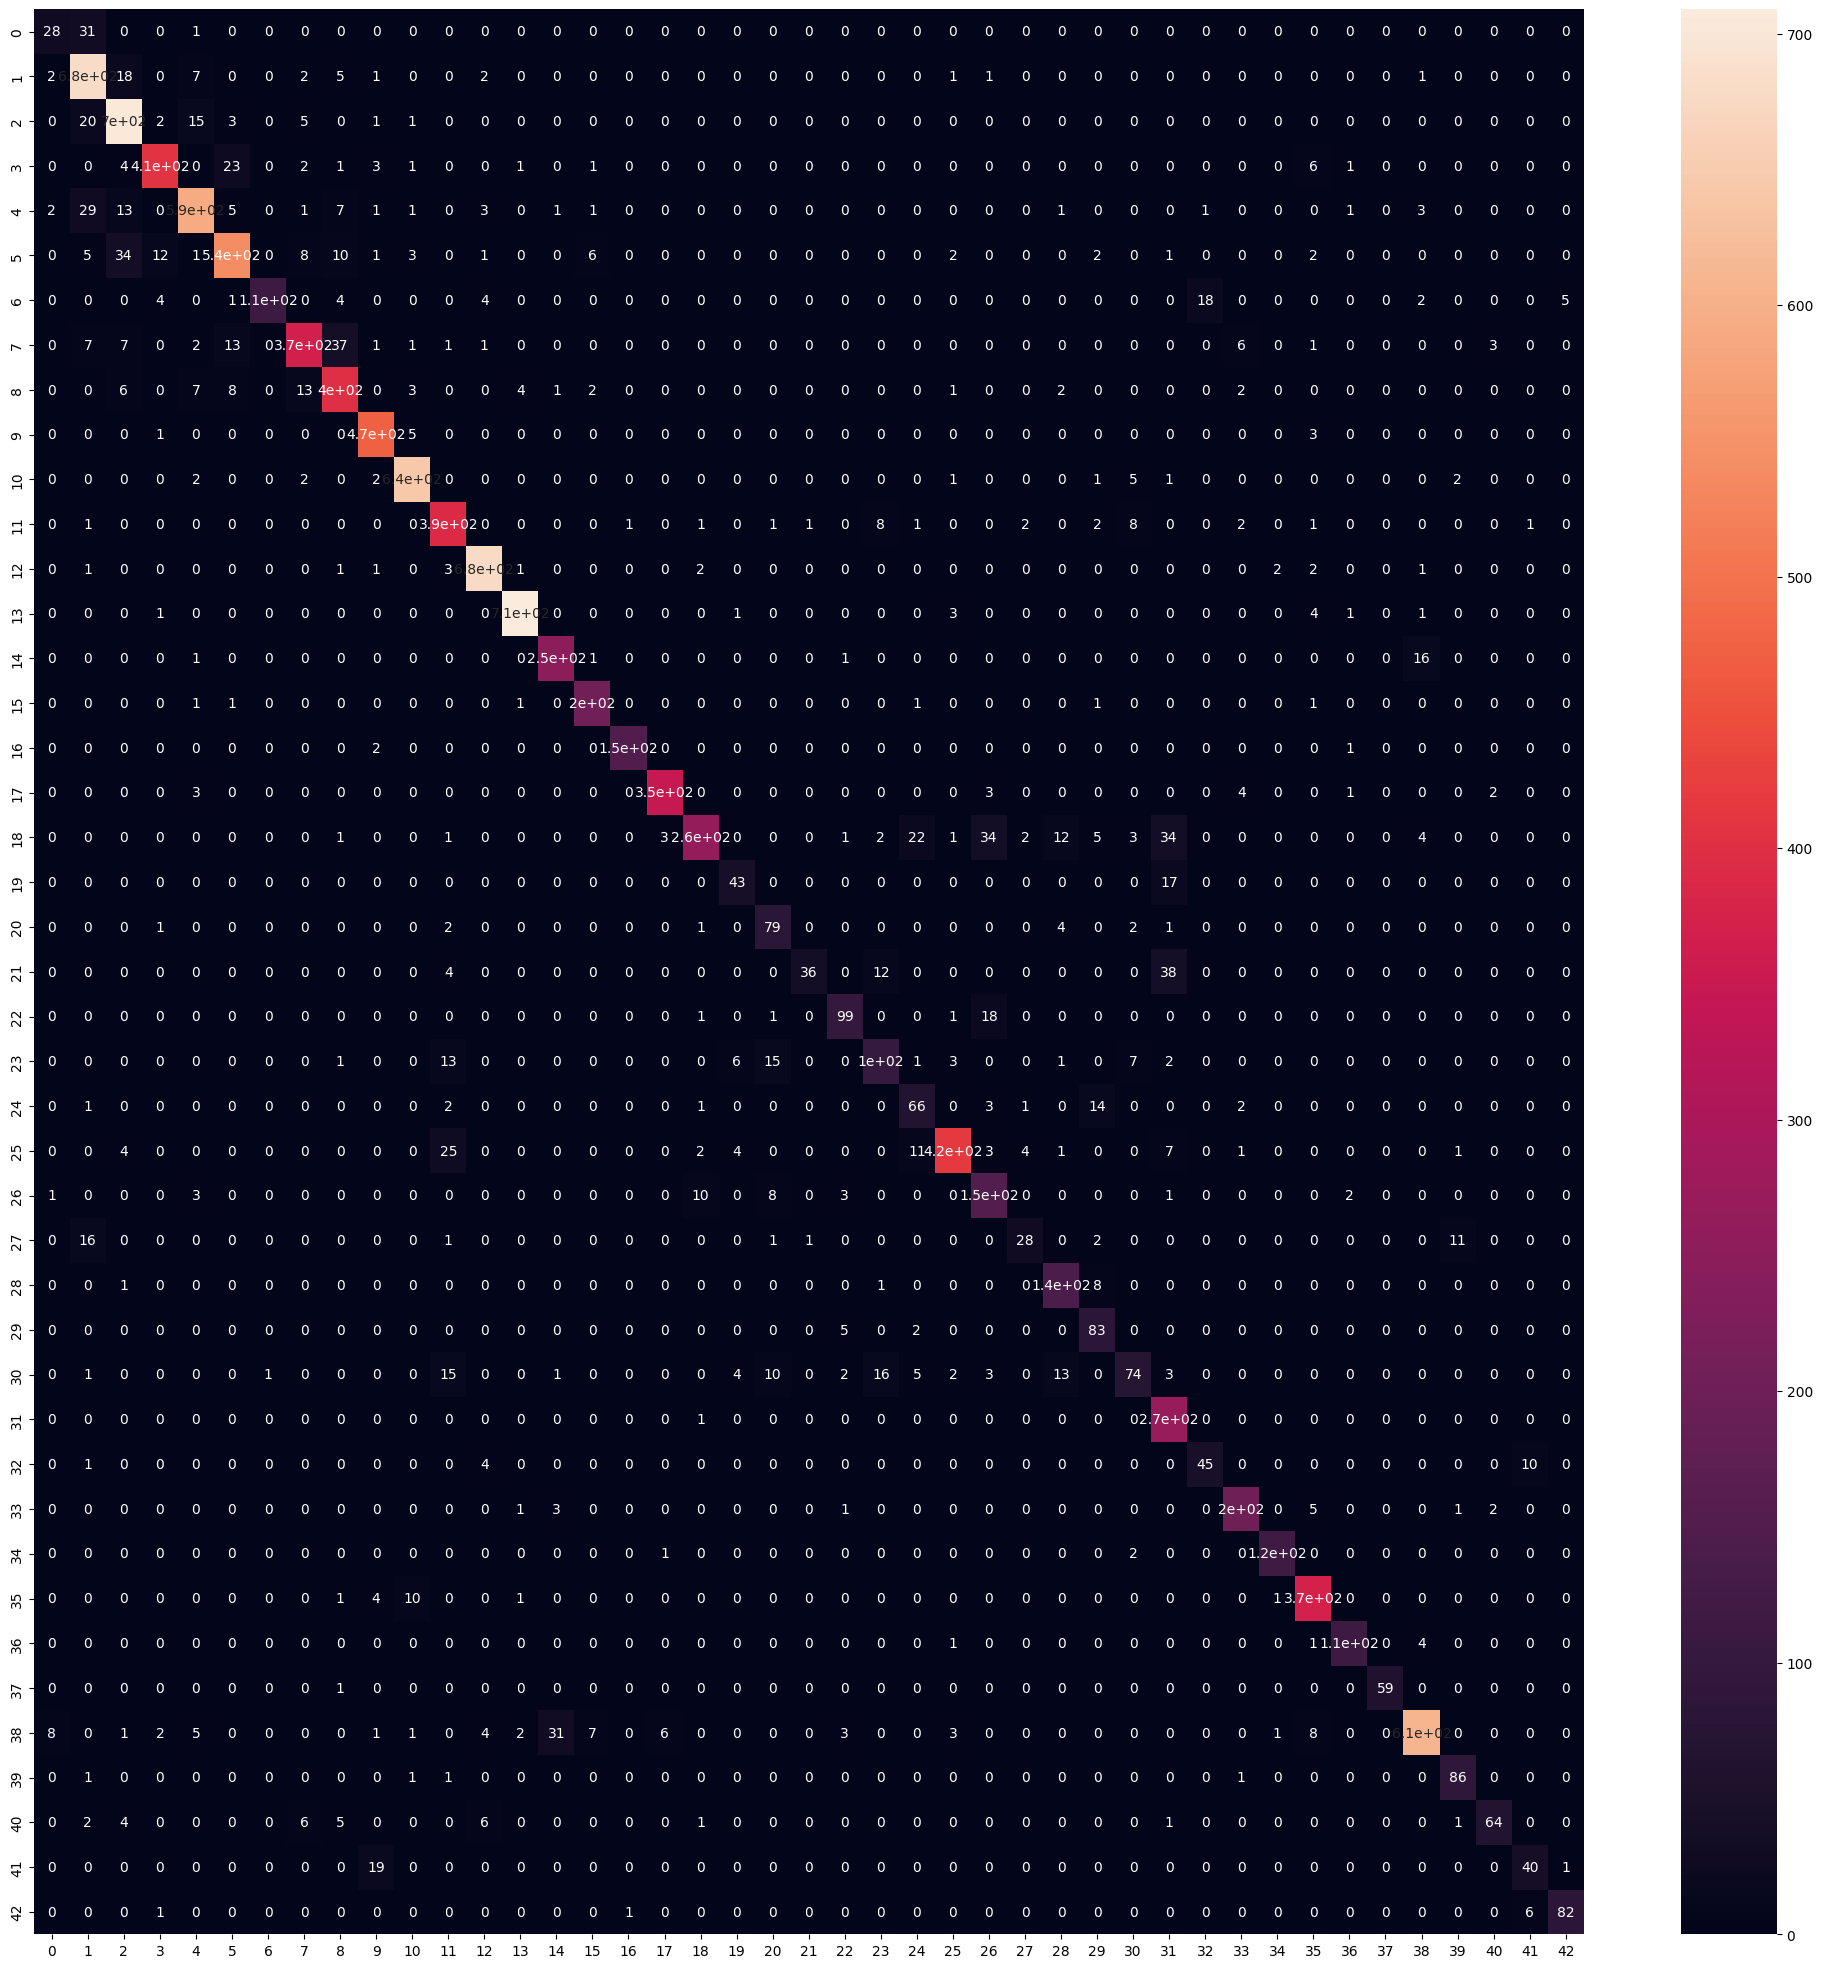

In [29]:
test_architecture(CNN, 500, 15)

## Model Architecture - 4th Version

In [66]:
from tensorflow.keras import regularizers

CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5,5), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(84, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 6)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 5, 5, 16)         

Epoch 1/15
70/70 [==============================] - 17s 204ms/step - loss: 3.2203 - accuracy: 0.1700 - val_loss: 2.6294 - val_accuracy: 0.3617
Epoch 2/15
70/70 [==============================] - 14s 197ms/step - loss: 1.7457 - accuracy: 0.5287 - val_loss: 1.2038 - val_accuracy: 0.6803
Epoch 3/15
70/70 [==============================] - 14s 204ms/step - loss: 1.0087 - accuracy: 0.7200 - val_loss: 0.8579 - val_accuracy: 0.7696
Epoch 4/15
70/70 [==============================] - 13s 192ms/step - loss: 0.7498 - accuracy: 0.7957 - val_loss: 0.6969 - val_accuracy: 0.8331
Epoch 5/15
70/70 [==============================] - 13s 193ms/step - loss: 0.6055 - accuracy: 0.8369 - val_loss: 0.6392 - val_accuracy: 0.8549
Epoch 6/15
70/70 [==============================] - 14s 199ms/step - loss: 0.5195 - accuracy: 0.8610 - val_loss: 0.5445 - val_accuracy: 0.8712
Epoch 7/15
70/70 [==============================] - 13s 192ms/step - loss: 0.4537 - accuracy: 0.8841 - val_loss: 0.5017 - val_accuracy: 0.8737

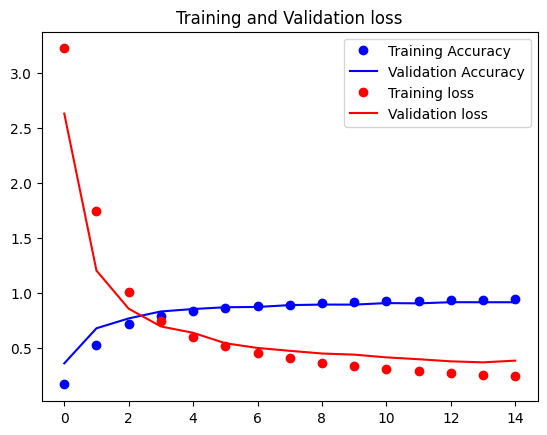

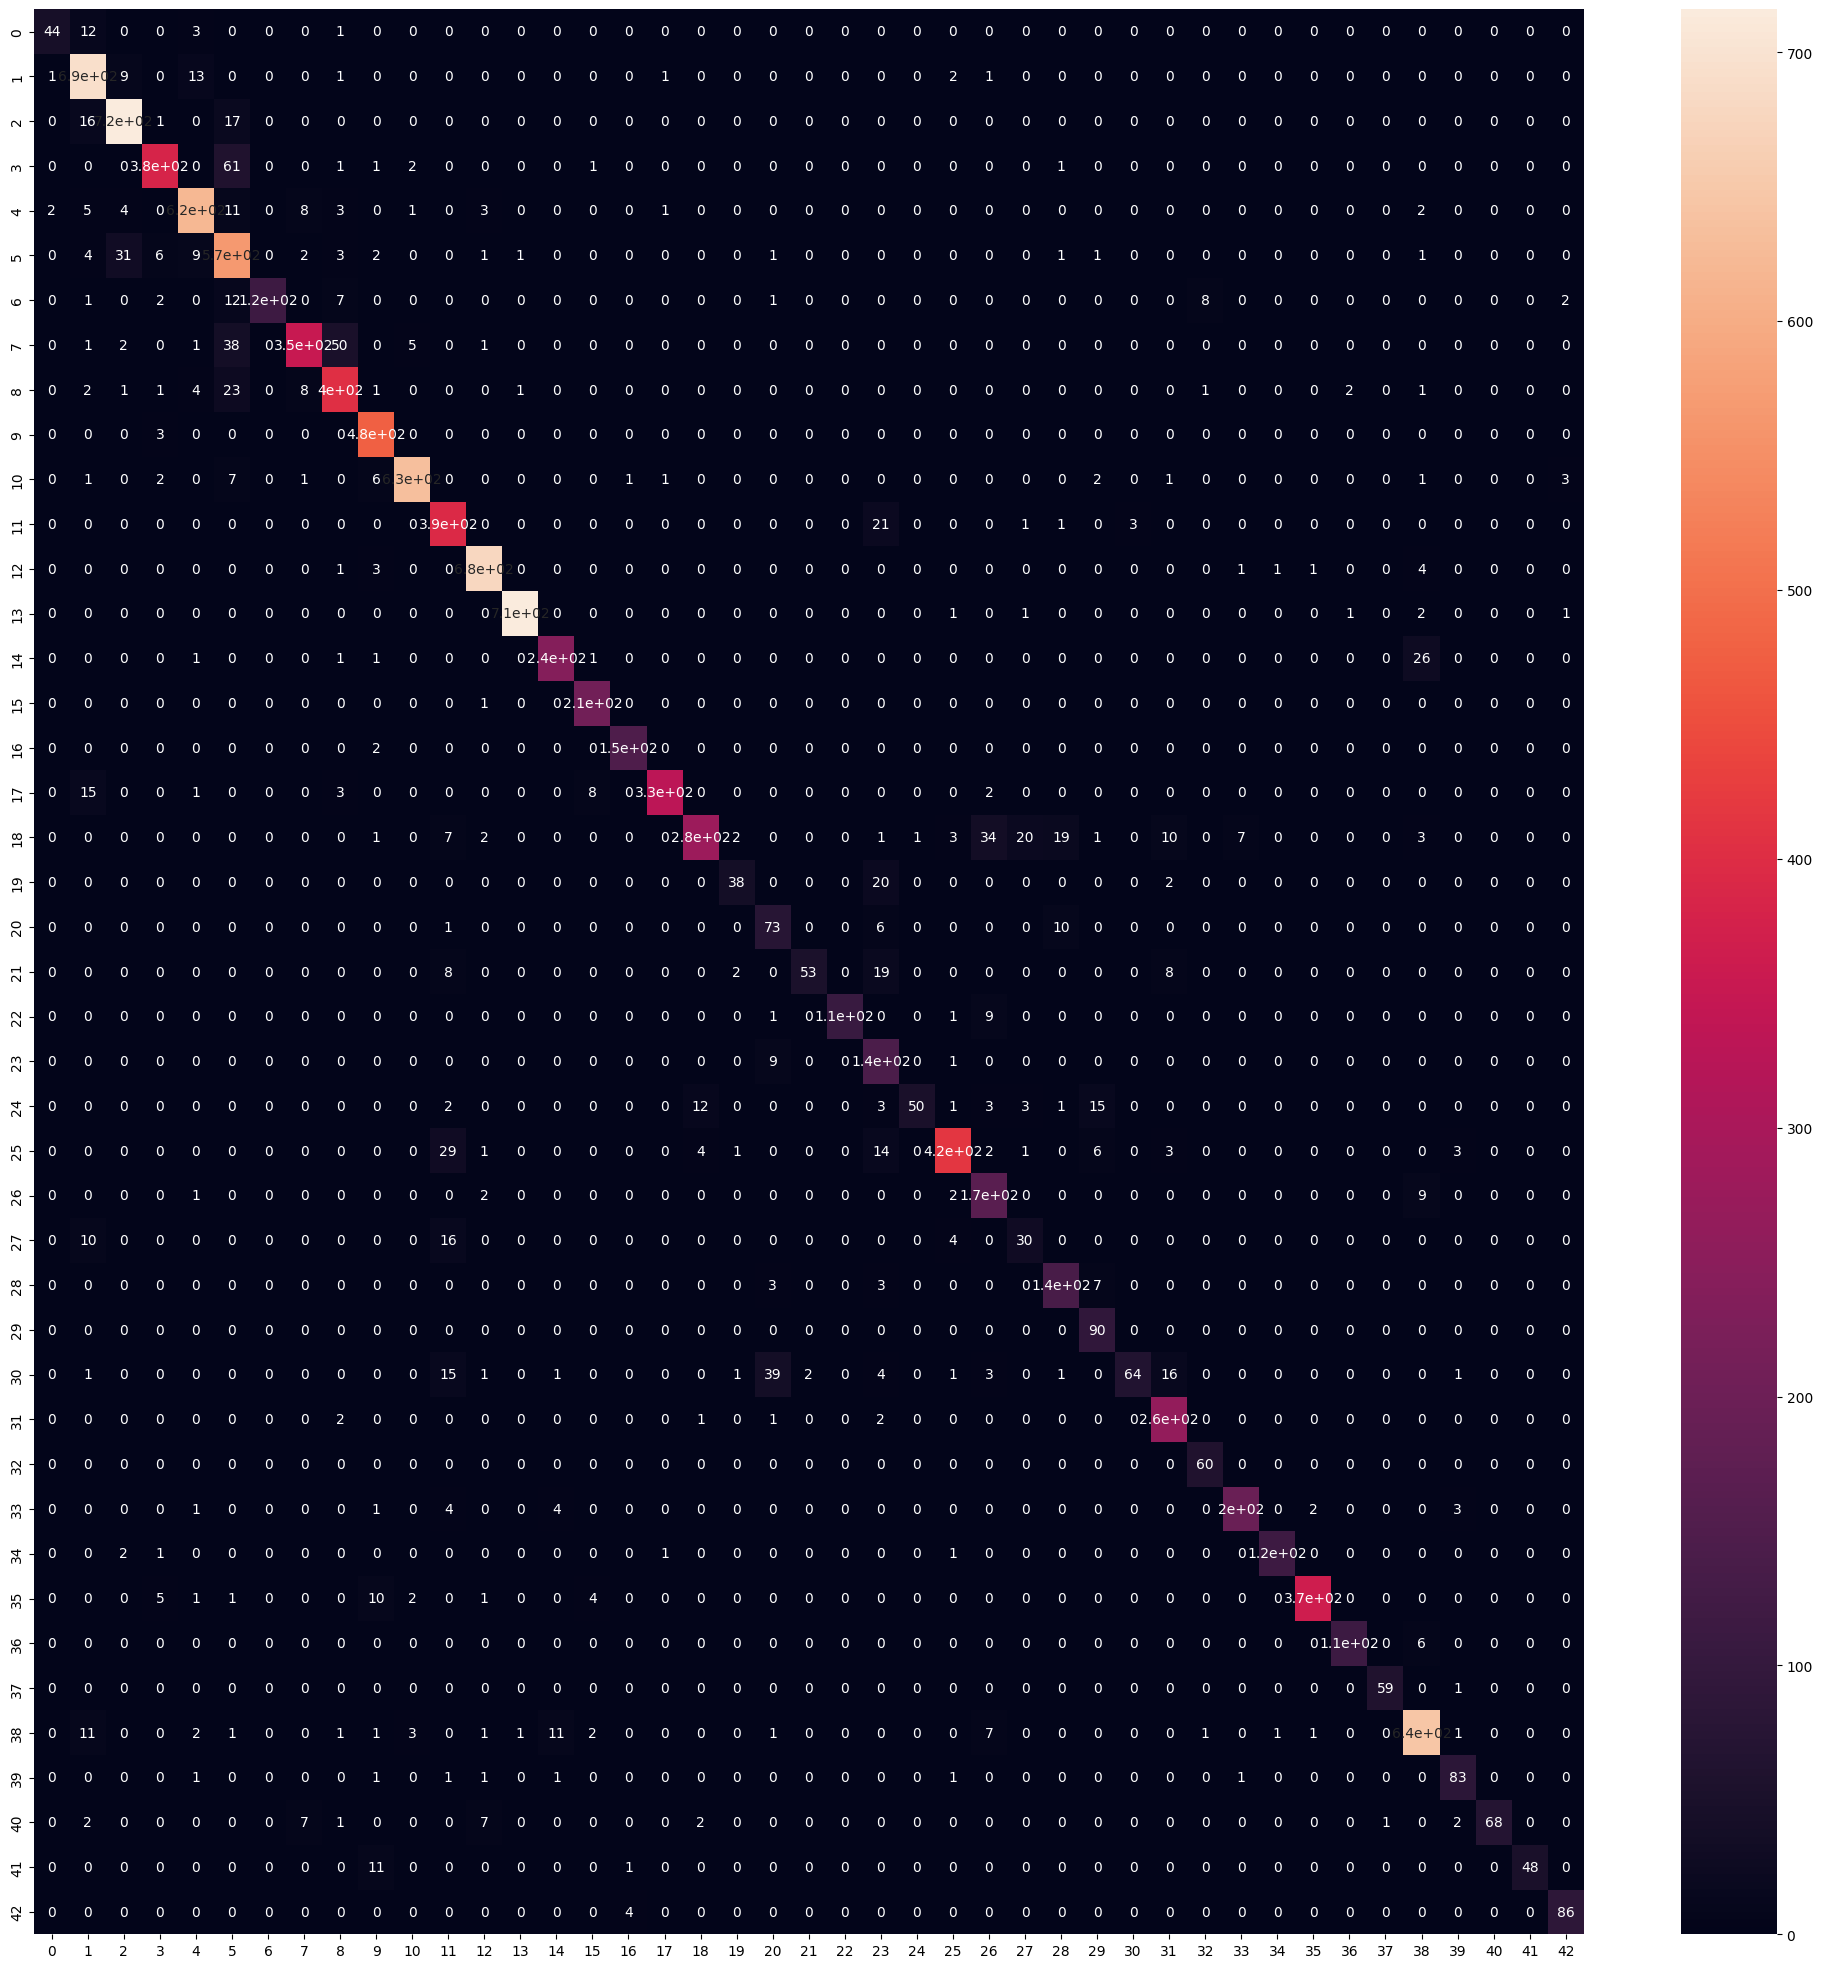

In [31]:
test_architecture(CNN, 500, 15)

## Model Architecture - 5th Version

In [45]:
from tensorflow.keras import regularizers

CNN = models.Sequential()

CNN.add(layers.Conv2D(16, (2,2), activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(32, (2,2), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(8, (2,2), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(84, activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 31, 31, 16)        80        
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 15, 15, 16)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 32)        2080      
                                                                 
 dropout_30 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 8)         1032      
                                                     

Epoch 1/80
70/70 [==============================] - 15s 178ms/step - loss: 3.4881 - accuracy: 0.0810 - val_loss: 3.4304 - val_accuracy: 0.1345
Epoch 2/80
70/70 [==============================] - 12s 172ms/step - loss: 2.8273 - accuracy: 0.2447 - val_loss: 2.3734 - val_accuracy: 0.3227
Epoch 3/80
70/70 [==============================] - 12s 175ms/step - loss: 1.8429 - accuracy: 0.4728 - val_loss: 1.5197 - val_accuracy: 0.5667
Epoch 4/80
70/70 [==============================] - 12s 174ms/step - loss: 1.3170 - accuracy: 0.6149 - val_loss: 1.1132 - val_accuracy: 0.7007
Epoch 5/80
70/70 [==============================] - 12s 175ms/step - loss: 1.0046 - accuracy: 0.7064 - val_loss: 0.8133 - val_accuracy: 0.7821
Epoch 6/80
70/70 [==============================] - 12s 174ms/step - loss: 0.7985 - accuracy: 0.7696 - val_loss: 0.6714 - val_accuracy: 0.8209
Epoch 7/80
70/70 [==============================] - 12s 176ms/step - loss: 0.6701 - accuracy: 0.8078 - val_loss: 0.5690 - val_accuracy: 0.8694

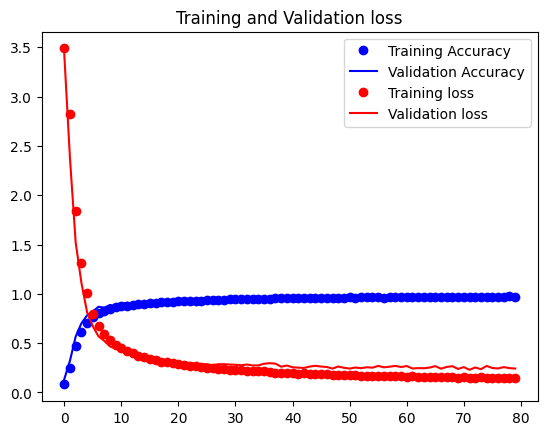

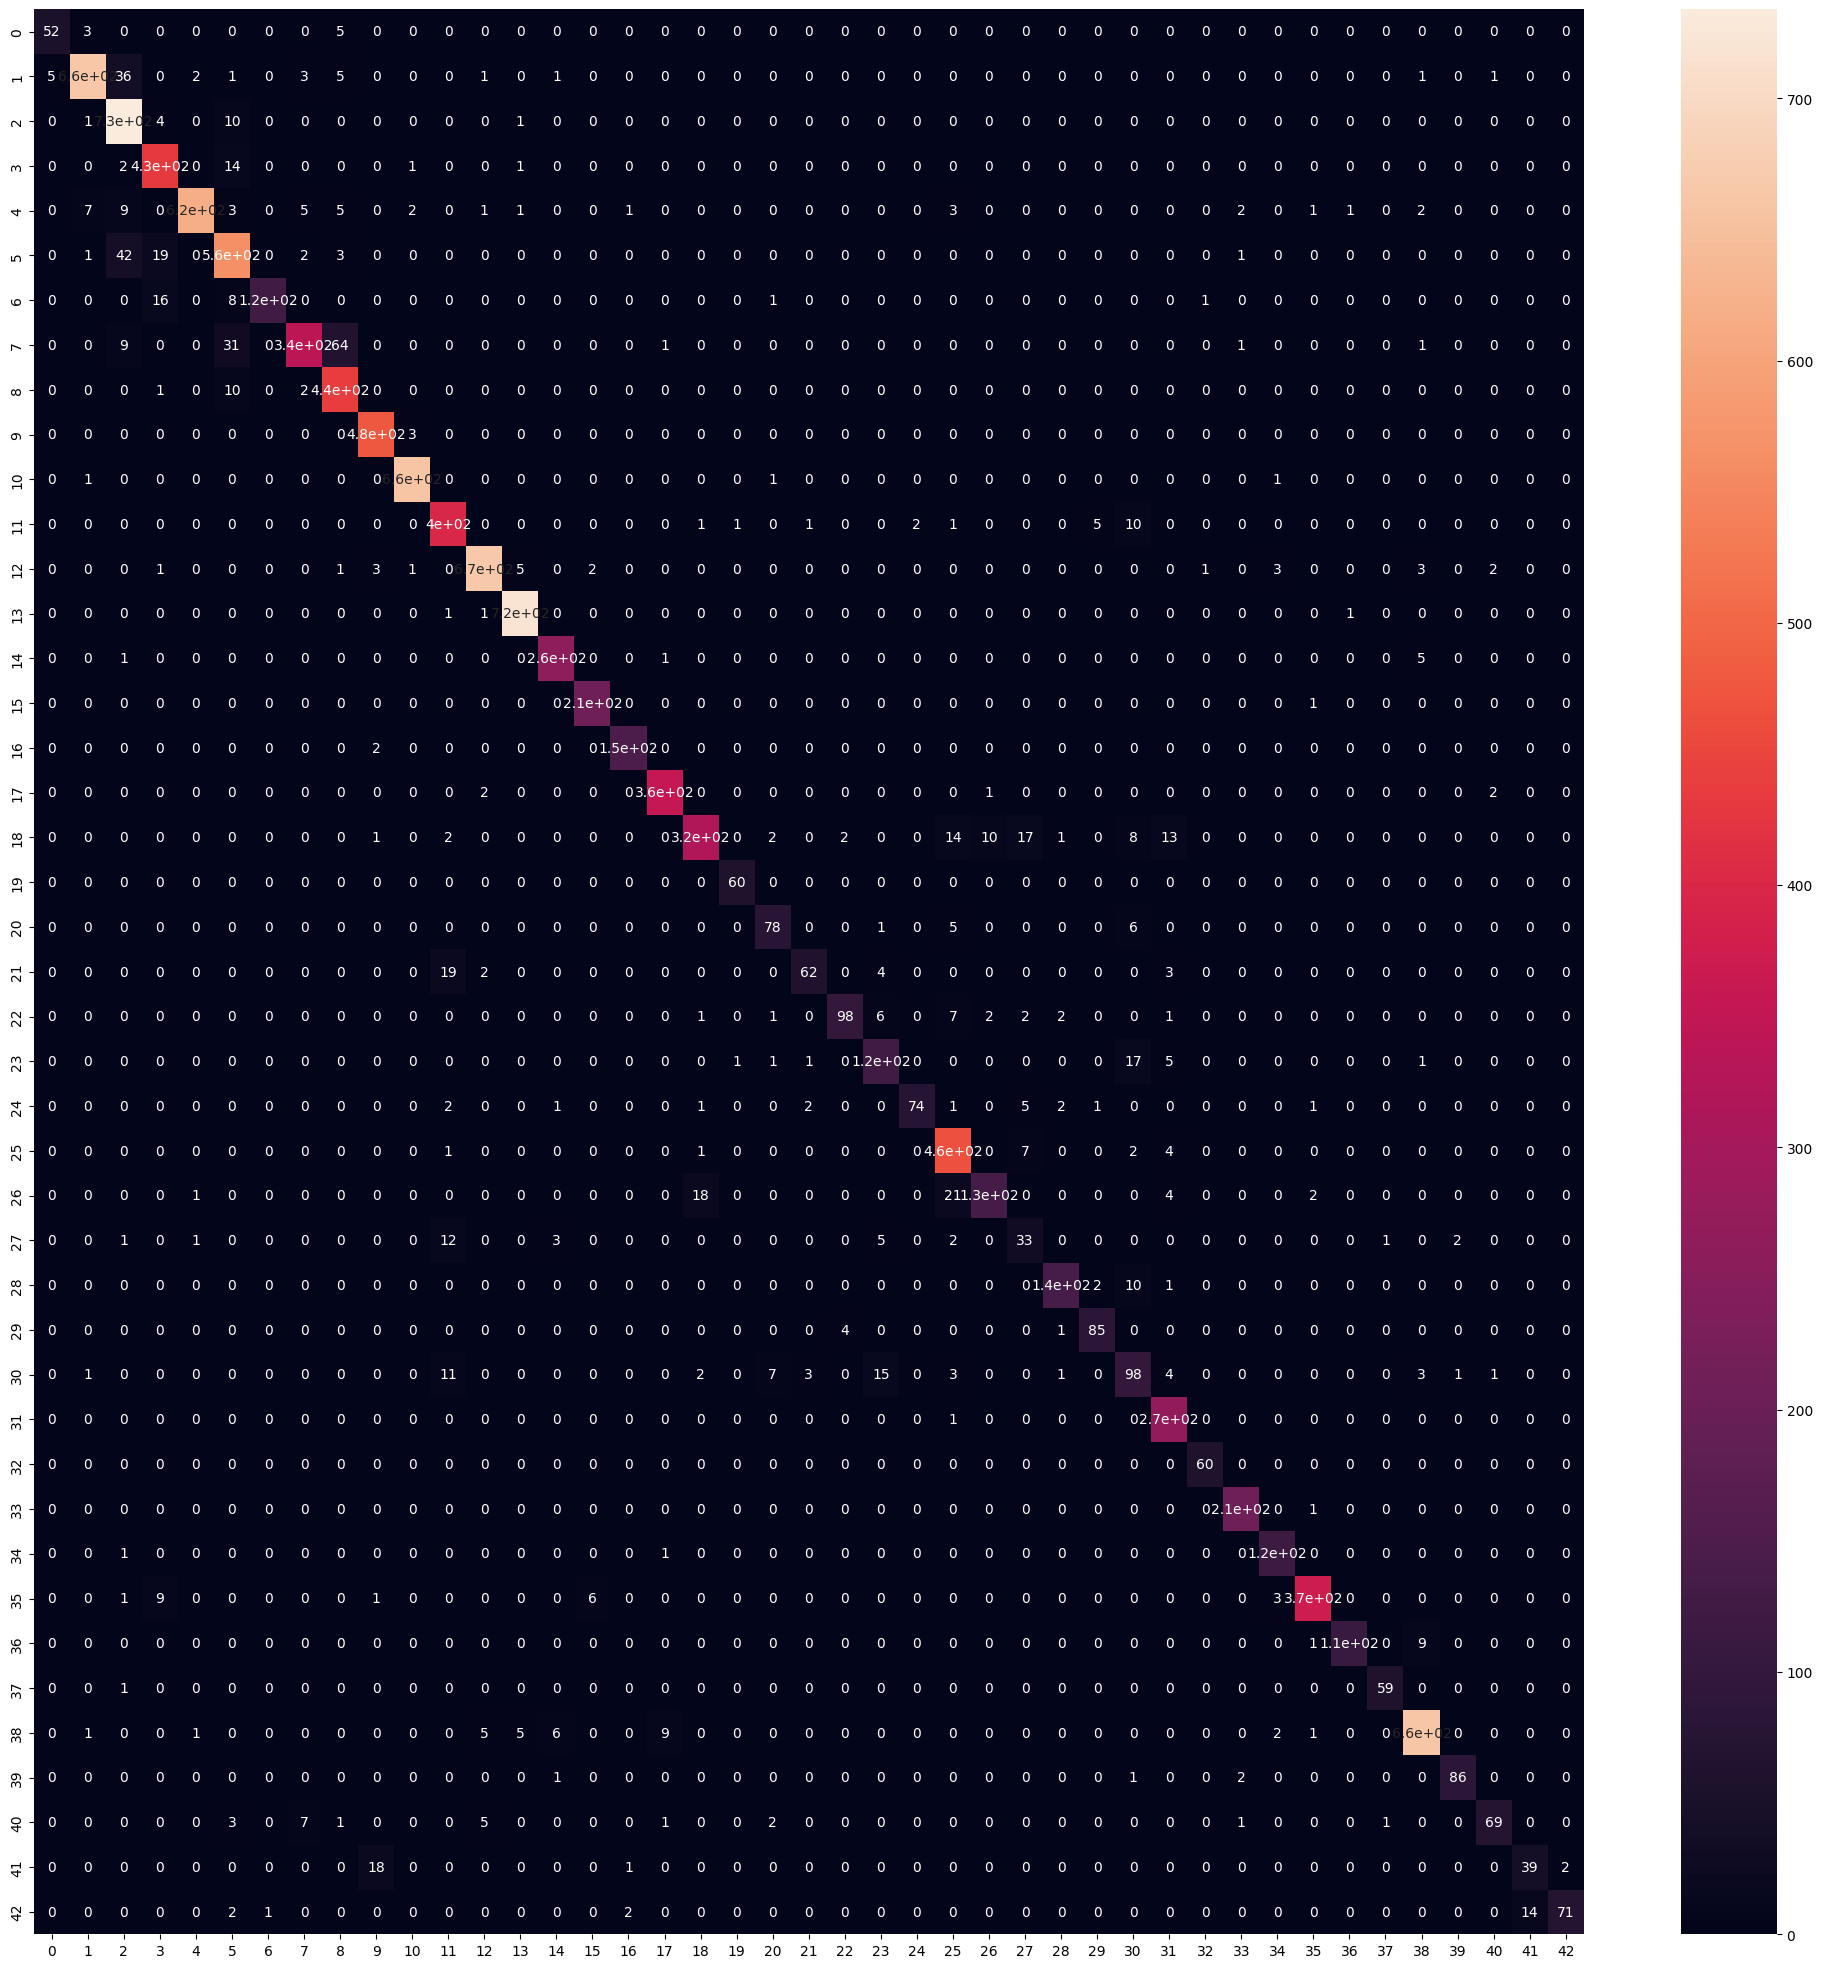

In [43]:
test_architecture(CNN, 500, 10)